---

This Colab was initially developed by [Jonathan Spencer](https://jspencer12.github.io) for the F2020 offering of _Safety-Critical Robotic Systems_.

The Optimization section was developed by [Haimin Hu](https://haiminhu.org) for the F2021 offering.

---

### ECE 539/COS 512, Fall 2021
# Code Demo 2 - Planning

A planning task typically consists of a well defined origin and goal configuration, and we wish to find the lowest cost strategy for the robot to move from the origin to the goal while avoiding collision with obstacles. This may seem trivial for 2-D tasks, but as we add in complicated movement dynamics (steering a car) or add dimensions, such as the case of robotic arm with 7+ degrees of freedom that we wish to plan safe trajectories for, the task becomes quite challenging.

## Paths and Trajectories

* **Kinematic planners** try to find an efficient _path_ through the robot's configuration space. When we say _minimum-cost path_, the cost is usually the distance traveled, in which case the lowest cost path is the shortest path, but the environment may have other factors we wish to penalize (i.e. proximity to obstacles) and the cost can be more general.

* Often, the dynamics of the robot make the problem trickier, and we can't expect it to follow arbitrary paths. To handle these cases, **kinodynamic planners** reason in terms of _trajectories_ through the state space over time, rather than purely geometric paths through the configuration space.

## Search and Optimization
Motion planning is often performed using two complementary types of methods.

* **Search-based planners** consider a finite set of candidate "waypoints" through the configuration or state space and try to connect them through short viable paths or trajectories. These methods can find gobally optimal solutions, but because they are discrete they often take a long time to iron out kinks and little inefficiencies, especially in high dimensions. 
* **Optimization-based planners** work in the continous space and typically use the derivatives of the cost (gradients and Hessians) to locally improve a candidate path or trajectory. They can only find a locally optimal solution, but they can do it comparatively fast, which makes them great at pairing up with their search-based friends.

In this codelab, we'll explore these different types of planners. We've linked to the original papers, so if you're interested in learning more, they can be fun to read.

# Search
The first search algorithms, developed in the 1950s and 1960s are **Graph-Based Planners**, which require a pre-specified graph of nodes and edges. Given such a graph, they can find the minimum-cost path quite efficiently, but building the graph can be demanding, especially as the dimensionality increases. Modern **Sampling-Based Planners** build a graph on the fly and are much more efficient.

We will explore both types of planners here, starting with the older graph-based algorithms.

In [ ]:
!pip install scikit-optimize      #Dependancy to install

     |████████████████████████████████| 101 kB 2.2 MB/s 


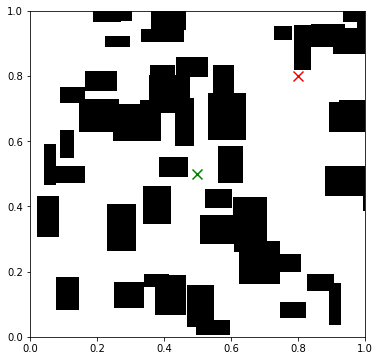

In [ ]:
#@markdown #### *Generating Obstacles*
#@markdown First we'll generate a task with some obstacles to plan around. Obstacles are generated randomly, so try playing with the number of obstacles and adjust the random seed until you get a setting you like.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
#50,7
#### Define origin and goal
origin = [.5,.5]
goal = [.8,.8]

#### Detect Collisions
def point_has_collision(point,obst_array):
  '''checks for any obstacle collision
     point=[x,y], obst=[[x,y,width,height],...]
     requires o_x < p_x < (o_x + o_w) and o_y < p_y < (o_y + o_h)'''
  return ((point[0]>=obst_array[:,0])
         *(point[0]<=(obst_array[:,0]+obst_array[:,2])) 
         *(point[1]>=obst_array[:,1])
         *(point[1]<=(obst_array[:,1]+obst_array[:,3]))).any()

#### Define Obstacles
n_obst = 50             # @param {type:"slider", min:2, max:200, step:1}
random_seed =          7#@param {type:"integer"}
valid = False           # Must regenerate obst sets until we find a valid one
while not valid:
  np.random.seed(random_seed)        
  obst_array = np.random.rand(n_obst,4) #obst are defined by [x,y,width,height]
  obst_array[:,2:] = .8*(obst_array[:,2:]+.3)/np.sqrt(n_obst) #Scale w,h to make sense
  valid = not (point_has_collision(origin,obst_array)
            or point_has_collision(goal,obst_array))
  random_seed += 100


#### Plot the task
#Stick this in a function since we'll be doing it a lot
def plot_task(origin,goal,obst_array): 
  obst_collection = PatchCollection([Rectangle(xy=obst_array[i,:2],
                                               width=obst_array[i,2],
                                               height=obst_array[i,3])\
                                     for i in range(n_obst)], facecolor='black')
  plt.gca().add_collection(obst_collection)
  plt.gca().set(xlim=(0, 1), ylim=(0, 1))
  plt.scatter(origin[0],origin[1],c='g',marker='x',s=100)
  plt.scatter(goal[0],goal[1],c='r',marker='x',s=100)

plt.figure('task',figsize=(6,6))
plot_task(origin,goal,obst_array)
plt.show()

## Graph-Based Planners

#### Building a graph for graph-dependent planners

One way to build the graph is to start with a regular lattice or a uniform pseudorandom grid of points like a [Halton or a Hammersly Sequence](https://en.wikipedia.org/wiki/Low-discrepancy_sequence#Halton_sequence) and connect the nearest neighbors, discarding points in the obstacles. Alternatively, with a [Probabilistic Roadmap](https://en.wikipedia.org/wiki/Probabilistic_roadmap), we randomly add points one by one (perhaps according to some prior distribution) until the desired density is achieved, connecting nearest neighbors in the same way. It's useful to use pseudorandom sequences like a Halton Sequence because they achieve more uniform coverage than if we just pulled random samples from a hat.

Try playing with the number of nodes in the graph or the number of neighbors used to create the edges of the graph.

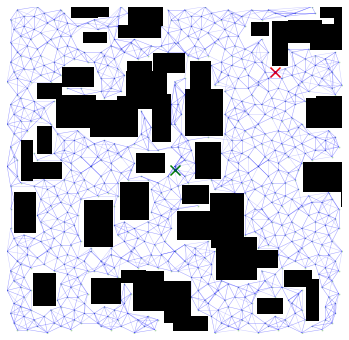

In [ ]:
from skopt.sampler import Hammersly
from sklearn.neighbors import kneighbors_graph as knn_graph

#### Generate nodes
num_nodes = 1000 # @param {type:"slider", min:100, max:2000, step:100}
scale = 100       #This just needs to be big enough for integer grid
all_nodes = np.array(Hammersly().generate([(0,scale),(0,scale)],num_nodes))/scale
all_nodes = np.vstack([origin,goal,all_nodes]) #add origin/goal to graph
valid_inds = [i for i in range(len(all_nodes))\
              if not point_has_collision(all_nodes[i,:],obst_array)]
nodes = all_nodes[valid_inds,:]   #filter invalid nodes


#### Functions for detecting edge collisions
def edge_has_collision(p0,p1,obst_array):
  '''Check if edge cuts through any obst in obst_array
    p0,p1 = [x,y] obst_array = [[x,y,width,height],... ]

    For a vector Z and point q, we can determine whether q is on the left or
    right of Z by forming Z_perp = [Z[1],-Z[0]] and looking at the sign of the
    the inner product <Z_perp,q>. If Z is centered at z0, we insted use
    sign(<Z_perp,q-z>)

    Now consider vector p = p1-p0, and corners of obst c0,c1,c2,c3
    For collision we require corners on different sides of p, and that p0 and p1
    be on opposite sides of two planes of obst. Since those planes are vertical/
    horizontal in this case, we don't have to mess with inner products'''
  p0,p1 = np.array(p0), np.array(p1)
  p = p1-p0
  p_perp = [p[1],-p[0]]
  c0 = obst_array[:,:2]  #bottom left
  c1 = np.vstack([obst_array[:,0]+obst_array[:,2],obst_array[:,1]]).T #bottom right
  c2 = np.vstack([obst_array[:,0]+obst_array[:,2],obst_array[:,1]+obst_array[:,3]]).T #top right
  c3 = np.vstack([obst_array[:,0],obst_array[:,1]+obst_array[:,3]]).T #top left
  corner_split = np.abs(np.sign(np.inner(p_perp,c0-p0))+np.sign(np.inner(p_perp,c1-p0))
                       +np.sign(np.inner(p_perp,c2-p0))+np.sign(np.inner(p_perp,c3-p0)))<4

  plane_intersect = np.sum(np.abs(np.sign(p0-c0)-np.sign(p1-c0))
                          +np.abs(np.sign(p0-c2)-np.sign(p1-c2)),axis=1)>=4
  return (corner_split * plane_intersect).any()

def eliminate_edges(G,nodes,obst_array):
  '''Given connectivity matrix G, return new matrix with bad edges removed'''
  edges = [*zip(*np.nonzero(G))]
  G_new = np.zeros(G.shape)
  for edge in edges:
    if not edge_has_collision(nodes[edge[0]],nodes[edge[1]],obst_array):
      G_new[edge[0],edge[1]] = 1
  return G_new

#### Generate valid graph edges
n_neighbors = 6 # @param {type:"slider", min:2, max:10, step:1}
G_raw = knn_graph(nodes, n_neighbors, mode='connectivity', include_self=False)
G = eliminate_edges(G_raw,nodes,obst_array)
edges = [*zip(*np.nonzero(G))]

#### Plot the graph to search over
# Another helpful function
def plot_graph(nodes,edges,node_color='green',edge_color='blue',opacity=1,linewidth=.5):
  if edge_color is not None:
    for edge in edges:
      x,y = (nodes[edge[0]][0],nodes[edge[1]][0]),(nodes[edge[0]][1],nodes[edge[1]][1])
      plt.plot(x,y,linewidth=linewidth,c=edge_color,alpha=opacity)
  if node_color is not None:
    plt.scatter(nodes[:,0],nodes[:,1],s=1,c=node_color,alpha=opacity)

plt.figure(figsize=(6,6))
plot_graph(nodes,edges,opacity=.2)
plot_task(origin,goal,obst_array)
#Plot the ones we eliminated if you want
#plot_graph(nodes,[*zip(*np.nonzero(G_raw-G))],edge_color='red')
plt.axis('off')
plt.show()

### Dijkstra
[Dijkstra's algorithm](http://www-m3.ma.tum.de/foswiki/pub/MN0506/WebHome/dijkstra.pdf) is probably *the* classic graph search algorithm. It keeps track of which nodes haven't yet visited, and always chooses the closest unvisited node to explore next ("best-first search"). This approach results in an exploration region that expands radially in all directions from the origin until it hits the goal.

I've hidden the implementation of it in the section below. If you haven't ever coded it before, I highly recommend coding up your own implementation, then verifying that you get the same result.

In [ ]:
#@markdown ### *Hidden Djikstra implementation*
#@markdown Double click here to reveal code. To write your own, create a new codeblock below following this format and compare the outputs of the two functions.

#@markdown ``` def my_own_Dijkstra(nodes,G,origin_ind,goal_ind): ``` <br>
#@markdown &emsp; &emsp;``` return shortest_path # (a list of edges i.e. [(0,4),(4,8),...])```
def Dijkstra(nodes,G,origin_ind,goal_ind):
  '''Uses L2 dist to search for shortest path from source to goal over graph G
  nodes = [[x,y]...] (len N), G = NxN binary connectivity matrix,
  origin_ind, goal_ind = int [0,...,N-1]'''
  n_nodes = len(nodes)
  visited_edges = []
  unvisited = [i for i in range(n_nodes)]
  dist = np.array([np.infty for i in range(n_nodes)])
  prev = [None for i in range(n_nodes)]
  dist[origin_ind] = 0

  while len(unvisited)>0:
    u_ind = np.argmin(dist[unvisited])
    u = unvisited[u_ind]
    unvisited.pop(u_ind)

    if u == goal_ind:
      break
  
    for v in np.nonzero(G[u,:])[0]:
      alt = dist[u] + np.linalg.norm(np.array(nodes[u])-np.array(nodes[v]))
      visited_edges.append((u,v))
      if alt < dist[v]:
        dist[v] = alt
        prev[v] = u
  
  shortest_path = []
  u = goal_ind
  while prev[u] is not None:
    shortest_path.insert(0,(prev[u],u))
    u = prev[u]
  print('Dijkstra terminated after {} iterations'.format(n_nodes-len(unvisited)))
  return shortest_path,visited_edges

Dijkstra terminated after 334 iterations


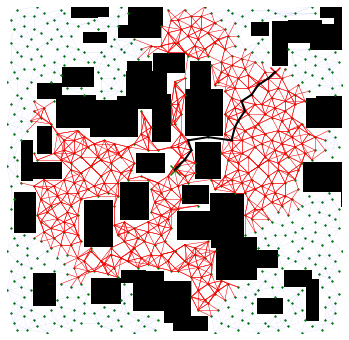

In [ ]:
shortest_path,visited_edges = Dijkstra(nodes,G,origin_ind=0,goal_ind=1)

plt.figure(figsize=(6,6))
plot_graph(nodes,edges,opacity=.05)
plot_task(origin,goal,obst_array)
plot_graph(nodes,visited_edges,edge_color='red')
plot_graph(nodes,shortest_path,edge_color='black',linewidth=2)
plt.axis('off')
plt.show()

### A* algorithm

You may have noticed that in Dijkstra, we spent quite a bit of time searching in the opposite direction from the goal. This is because we naively chose between candidate nodes.<br>
```u_ind = np.argmin(dist[unvisited])``` <br>
The next candidate is unexplored node with the smallest distance to the origin.

However, we know *where* the goal is, just not how to get there. Why don't we spend more time looking in the direction of the goal?

That's what [the A* algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4082128) does. It introduces a heuristic distance to prioritize the order in which nodes are visited. Let $o$ be the origin node, $g$ be the goal node, $\mathcal{U}$ be the set of unvisited nodes, $f$ be the true cost of traversing the graph between two nodes, and $h$ be the heuristic distance (which must be a lower bound on the true cost, $f$) then each of the two algorithms chooses the next node to explore as follows:

Dijkstra: $~~~u_{next} = \arg\min_{u\in\mathcal{U}} ~~f(o,u)$

A*: $~~~~~~~~~~u_{next} = \arg\min_{u\in\mathcal{U}} ~~f(o,u)+h(u,g)$   &emsp; &emsp; &emsp; &emsp;(lol, hug)

In this case (and most cases), the heuristic is the Euclidian distance to the goal, which is a lower bound of the graph traversal path to the goal since we will potentially avoid obstacles. With two small changes, we have a significant speedup.

Try copying and modifying the Dijkstra code above to see if you can get the same A* result as the one below.

In [ ]:
#@markdown ### *Hidden A-star implementation*
#@markdown Double click here to reveal code. To write your own, create a new codeblock below following this format and compare the outputs of the two functions.

#@markdown ``` def my_own_A_star(nodes,G,origin_ind,goal_ind): ``` <br>
#@markdown &emsp; &emsp;``` return shortest_path # (a list of edges i.e. [(0,4),(4,8),...])```
def A_star(nodes,G,origin_ind,goal_ind):
  '''Uses L2 dist to search for shortest path from source to goal over graph G
  nodes = [[x,y]...] (len N), G = NxN binary connectivity matrix,
  origin_ind, goal_ind = int [0,...,N-1]'''
  n_nodes = len(nodes)
  visited_edges = []
  unvisited = [i for i in range(n_nodes)]
  dist = np.array([np.infty for i in range(n_nodes)])
  heuristic = np.linalg.norm(np.array(nodes)-np.array(goal),axis=1)
  prev = [None for i in range(n_nodes)]
  dist[origin_ind] = 0

  while len(unvisited)>0:
    u_ind = np.argmin(dist[unvisited]+heuristic[unvisited])
    u = unvisited[u_ind]
    unvisited.pop(u_ind)

    if u == goal_ind:
      break
  
    for v in np.nonzero(G[u,:])[0]:
      alt = dist[u] + np.linalg.norm(np.array(nodes[u])-np.array(nodes[v]))
      visited_edges.append((u,v))
      if alt < dist[v]:
        dist[v] = alt
        prev[v] = u
  
  shortest_path = []
  u = goal_ind
  while prev[u] is not None:
    shortest_path.insert(0,(prev[u],u))
    u = prev[u]
  print('A* terminated after {} iterations'.format(n_nodes-len(unvisited)))
  return shortest_path,visited_edges

A* terminated after 38 iterations


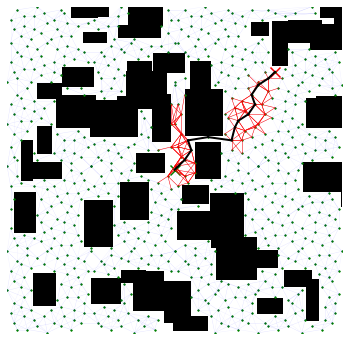

In [ ]:
shortest_path,visited_edges = A_star(nodes,G,origin_ind=0,goal_ind=1)

plt.figure(figsize=(6,6))
plot_graph(nodes,edges,opacity=.05)
plot_task(origin,goal,obst_array)
plot_graph(nodes,visited_edges,edge_color='red')
plot_graph(nodes,shortest_path,edge_color='black',linewidth=2)
plt.axis('off')
plt.show()

## Sampling-Based Planners
Both Dijkstra and A* had a lot of computational overhead even before execution, namely the need to build a lattice, discard nodes with collisions, build a graph, and check edges for collisions. Checking for node and edge collisions can often be some of the more costly computational operations, so we would like to check as little as possible. The implementations above can be further optimized to perform collision checking on-the-fly and to reduce the computational load of the "argmin" operation by searching over a smaller "frontier" set of candidate nodes. This is a fun activity if you'd like the practice. We'll now switch our focus to a set of planners that avoid much of this overhead.

### Rapidly-exploring Random Trees (RRT)
The original [RRT](http://msl.cs.illinois.edu/~lavalle/papers/Lav98c.pdf) algorithm is quite simple:

Begin with an empty graph, a source point and a goal region.
1. Randomly generate a new point $x_{rand}$
2. Find the nearest graph node $x_{near}$ to $x_{rand}$
3. Let $x_{new}$ be a new point that starts at $x_{near}$ and takes a $\Delta$ step in the direction of $x_{rand}$
4. If $x_{new}$ and the path to it are both valid, add it to the graph.
5. If $x_{new}$ is in the goal region (say, $\Delta$ away from goal point), quit.

Check out (or attempt!) the implementation below. Run it a few times and notice the types of paths it generates. Also contrast the runtime with the combined runtimes of the graph generation and Dijkstra/A* runtimes



In [ ]:
#@markdown ### *Hidden RRT implementation*
#@markdown Double click here to reveal code. To write your own, create a new codeblock below following this format and compare the outputs of the two functions.

#@markdown ``` def my_own_RRT(origin,goal,obst_array,delta=0.03,max_steps=1000):```<br>
#@markdown &emsp; &emsp;``` return nodes,G,shortest_path   #(list of coordinates, binary connectivity matrix, list of edges i.e. [(0,4),(4,8),...])```

## Make some helper methods first
def add_to_graph(node,parent_ind,nodes,G,parent):
  nodes.append(node)
  parent.append(parent_ind)
  G = np.pad(G,((0,1),(0,1)))
  G[parent_ind,-1] = 1
  G[-1,parent_ind] = 1
  return nodes,G,parent

def RRT(origin, goal, obst_array,delta=.05,max_steps=2000):
  nodes = [origin]
  G = np.array([[0]])
  parent = [None]
  shortest_path = []
  for step in range(max_steps):
    x_rand = np.random.rand(2)
    ind_near = np.argmin(np.linalg.norm(np.array(nodes)-x_rand,axis=1))
    x_near = np.array(nodes[ind_near])
    x_new = x_near + (x_rand-x_near)/np.linalg.norm(x_rand-x_near)*delta
    if not (point_has_collision(x_new,obst_array)
           or edge_has_collision(x_near,x_new,obst_array)):
      nodes,G,parent = add_to_graph(x_new,ind_near,nodes,G,parent)

      #Terminate if new point within delta of goal
      if (np.linalg.norm(x_new-np.array(goal))<max(delta,0.02)
        and not edge_has_collision(x_new,goal,obst_array)):
        nodes,G,parent = add_to_graph(goal,len(nodes)-1,nodes,G,parent)
        #chart shortest path
        u = len(nodes)-1
        while parent[u] is not None:
          shortest_path.insert(0,(parent[u],u))
          u = parent[u]
        break
  nodes = np.array(nodes)
  final_cost = 'N/A' if len(shortest_path)==0 else\
   sum([np.linalg.norm(nodes[e[0]]-nodes[e[1]]) for e in shortest_path])
  print('RRT terminated after {} iterations '\
        'with a cost of {}'.format(step+1,final_cost))
  return nodes,G,shortest_path



RRT terminated after 249 iterations with a cost of 0.5808638947137866


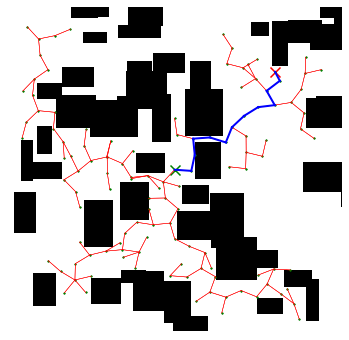

In [ ]:
#@markdown Play with delta and notice how the resulting path changes
delta = 0.05 # @param {type:"slider", min:0.01, max:0.2, step:0.01}
nodes,G,shortest_path = RRT(origin,goal,obst_array,delta=delta)
visited_edges = [*zip(*np.nonzero(G))]

plt.figure(figsize=(6,6))
plot_task(origin,goal,obst_array)
plot_graph(nodes,visited_edges,edge_color='red')
plot_graph(nodes,shortest_path,edge_color='blue',linewidth=2)
plt.axis('off')
plt.show()

You may have noticed that although RRT is quite efficient, the trajectories generated can be quite jagged because of how new points are added to the closest point on the graph, and the "shortest path" is sometimes not very short. This is because RRT does not guarantee the *shortest path*, it simply helps us quickly find a *feasible path*. You may also notice that sometimes the trees wrap around on themselves in inefficient ways. We can solve both of these issues with an optimized version of the algorithm.

### RRT* (Optimal Rapidly-exploring Random Trees)

[The RRT* Algorithm](https://arxiv.org/pdf/1105.1186.pdf) is optimal in the sense that when the number of nodes reaches infinity, it returns the true shortest path. However, it still does a pretty good job with a finite number of nodes. RRT* accomplishes this with two key modifications to RRT:
- **Min cost neighbor vs closest neighbor** - We keep track of the accumulated cost for every node. When we add a new node, rather than simply attaching the new node to the closest node, we search within a neighborhood for the node with the lowest cost, and instead attach to that node.
- **Rewiring** - After we have added a new node, we search within a neighborhood and rewire any nodes whose total cost decreases by passing through the new node.

In [ ]:
#@markdown ### _Hidden RRT* implementation_
#@markdown Double click here to reveal code. To write your own, create a new codeblock below following this format and compare the outputs of the two functions.

#@markdown ``` def my_own_RRT_star(origin, goal, obst_array,delta=.05,neighbor_dist=.2,max_steps=1000):```<br>
#@markdown &emsp; &emsp;``` return nodes,G,shortest_path   #(list of coordinates, binary connectivity matrix, list of edges i.e. [(0,4),(4,8),...])```

def add_and_rewire(x_new,nodes,neighbor_dist,obst_array,cost,G,parent):
  ''' Wires to neighbor with lowest cost, rewires neighbors through x_new if
    doing so decreases their cost '''
  nodes_array = np.array(nodes)

  #Find neighbors and filter out ones with edge collisions
  X_all_neighbors = (np.linalg.norm(nodes_array-x_new,\
                                    axis=1)<neighbor_dist).nonzero()[0]
  X_neighbors = np.array([i for i in X_all_neighbors\
                          if not edge_has_collision(nodes[i],x_new,obst_array)])
  if len(X_neighbors)==0:
    return nodes,G,parent,cost

  #Connect x_new to lowest cost node in neighborhood
  cost2neighbors = np.linalg.norm(np.reshape(nodes_array[X_neighbors],
                                             (-1,len(x_new)))-x_new,axis=1)
  neighbor_costs = np.array(cost)[X_neighbors]
  neighbor_ind_min = np.argmin(neighbor_costs + cost2neighbors)
  ind_min = X_neighbors[neighbor_ind_min]
  nodes,G,parent = add_to_graph(x_new,ind_min,nodes,G,parent)
  cost.append(cost[ind_min]+cost2neighbors[neighbor_ind_min])

  #Rewire neighbor nodes through x_new if doing so decreases their cost
  neighbor_rewire_inds = (neighbor_costs > cost2neighbors+cost[-1]).nonzero()[0]
  for neighbor_ind in neighbor_rewire_inds:
    ind = X_neighbors[neighbor_ind]
    cost[ind] = cost2neighbors[neighbor_ind]+cost[-1]
    G[parent[ind],ind] = G[ind,parent[ind]] = 0
    parent[ind] = len(nodes)-1
    G[parent[ind],ind] = G[ind,parent[ind]] = 1
  return nodes,G,parent,cost

def RRT_star(origin,goal,obst_array,delta=.05,neighbor_dist=.2,max_steps=1000):
  nodes = [origin]
  G = np.array([[0]])
  parent = [None]
  cost = [0]
  shortest_path = []
  for step in range(max_steps-1):
    x_rand = np.random.rand(2)    #Choose a random location
    nodes_array = np.array(nodes)
    ind_near = np.argmin(np.linalg.norm(nodes_array-x_rand,axis=1))
    x_near = np.array(nodes[ind_near])    #find nearest graph point to x_rand
    x_new = x_near + (x_rand-x_near)/np.linalg.norm(x_rand-x_near)*delta
    
    if not (point_has_collision(x_new,obst_array)
           or edge_has_collision(x_near,x_new,obst_array)):

      #Add new node to lowest cost neighbor and rewire neighbors
      nodes,G,parent,cost = add_and_rewire(x_new,nodes,neighbor_dist,
                                           obst_array,cost,G,parent)
  
  #add goal and chart path
  nodes,G,parent,cost = add_and_rewire(np.array(goal),nodes,neighbor_dist,
                                        obst_array,cost,G,parent)
  if (nodes[-1] == np.array(goal)).all():
    u = len(nodes)-1
    while parent[u] is not None:
      shortest_path.insert(0,(parent[u],u))
      u = parent[u]
    final_cost = cost[len(nodes)-1]
  else:
    final_cost = 'N/A'
  
  nodes = np.array(nodes)
  print('RRT* terminated after {} iterations '\
        'with a cost of {}'.format(step+2,final_cost))
  return nodes,G,shortest_path

RRT* terminated after 1000 iterations with a cost of 0.5369739978720206


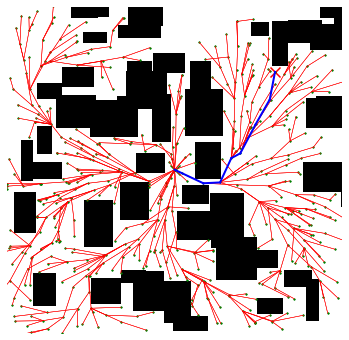

In [ ]:
#@markdown Unlike RRT which terminates once it finds a feasible path, RRT*
#@markdown terminates after a specified number of iterations, and returns
#@markdown the best path. Play with the number of iterations, delta, and 
#@markdown the neighborhood distance used for rewiring nodes. If the number
#@markdown of iterations is too small, it may not return a path to the goal.
delta = 0.05 # @param {type:"slider", min:0.01, max:0.2, step:0.01}
neighbor_dist = 0.1 # @param {type:"slider", min:0.05, max:0.3, step:0.01}
max_steps = 1000 # @param {type:"slider", min:100, max:3000, step:100}
nodes,G,shortest_path = RRT_star(origin, goal, obst_array,delta=delta,\
                                neighbor_dist=neighbor_dist,max_steps=max_steps)
visited_edges = [*zip(*np.nonzero(G))]

plt.figure(figsize=(6,6))
plot_task(origin,goal,obst_array)
plot_graph(nodes,visited_edges,edge_color='red')
plot_graph(nodes,shortest_path,edge_color='blue',linewidth=2)
plt.axis('off')
plt.show()

### Informed RRT\*
Although RRT\* provides a guarantee of asymptotic optimality, you may have noticed that it suffers from the same issue of Dijkstra, spending too much time searching in uninteresting regions. A\* solved that issue by adding the heuristic cost, guiding which graph nodes to choose next, rather than choosing the node currently closest to the origin.

In RRT* the inefficiency lies in the generation of random new points. The [Informed RRT*](https://arxiv.org/pdf/1404.2334.pdf) algorithm enables a massive speed up by focusing the generation of new points to the interesting area between origin and goal. Specifically, we sample points within an ellipse around the start and goal. As the quality of path improves, the ellipse shrinks.

This is especially helpful for high dimensional search problems, such as for a robotic arm with 7 degrees of freedom where we are looking for an optimal collision-free path from one arm configuration to another. RRT produces jerky, subotimal trajectories, while RRT* takes a long time to find an optimal solution because it wastes a lot of time searching in useless regions.

The "Informed RRT\*" tweak is a relatively straightforward addition to RRT\*.
Key changes:
 - Once a (suboptimal) start-goal path has been found, only sample new points inside a related ellipsoid rather than the entire space: any points outside of this ellipsoid can only be part of worse solutions.
 - Adjust ellipsoid shape based on current best solution.

Methods for sampling from an ellipse in 2D are provided below. Feel free to start with the RRT\* code provided above and try the modification yourself.

In [ ]:
def sample_in_ellipse(p0,p1,C,c_max,c_min=None):
  '''Samples random point from ellipse with focii p0,p1, length c_max
  
    requires rotation matrix C'''
  p0 = np.array(p0); p1 = np.array(p1)
  if np.isinf(c_max):
    x_rand = np.random.rand(len(p0))
  else:
    c_min = c_min or np.linalg.norm(p1-p0)
    center = (p0+p1)/2
    r = [c_max/2]
    r.extend([np.sqrt(c_max**2-c_min**2)/2 for i in range(1,len(p0))])
    L = np.diag(r) 
    x_rand = np.dot(np.dot(C,L),np.squeeze(sphere_sample(np.zeros_like(p0))))+\
     center
  return x_rand

def compute_rotation_matrix(p0,p1):
  ''' Computes matrix to rotate from hyperellipsoid frame to world frame'''
  p0 = np.array(p0); p1 = np.array(p1)
  a1 = (p1-p0)/np.linalg.norm(p1-p0)
  M = np.outer(a1,np.eye(len(a1),1))
  U,_,VT = np.linalg.svd(M)
  d = np.hstack((np.ones((len(p0)-2)),[np.linalg.det(U),np.linalg.det(VT)]))
  return np.linalg.multi_dot([U,np.diag(d),VT])

def sphere_sample(center,radius=1,n_pts=1):
  '''Generate n-dim gaussian vec, normalize, then scale by r**(1/n), r~U[0,1]'''
  pt = np.random.randn(n_pts,len(center))
  pt = pt/np.linalg.norm(pt,axis=1)[:,None]
  pt = pt*((np.random.rand(n_pts))**(1.0/len(center))*radius)[:,None]
  return pt+np.array(center)

#Code to test ellipse and sphere sampling
if 0:
  plt.figure()
  #pts = sphere_sample([1,1],2,1000)
  C = compute_rotation_matrix([0,0],[1,1])
  pts = np.array([sample_in_ellipse([0,0],[1,1],1.5,C) for i in range(1000)])
  plt.scatter(pts[:,0],pts[:,1])
  plt.axis('square')
  plt.show()

In [ ]:
#@markdown ### *Hidden Informed RRT-star implementation*
#@markdown Double click here to reveal code. To write your own, create a new
#@markdown codeblock below following this format and compare the outputs of the
#@markdown two functions.

#@markdown ``` def my_own_Informed_RRT_star(origin, goal, obst_array,```
#@markdown ``` delta=.05, neighbor_dist=.2,max_steps=1000):```<br>
#@markdown &emsp; &emsp;``` return nodes,G,shortest_path   ```
#@markdown ``` #(list of coordinates, binary connectivity matrix, ```
#@markdown ``` list of edges i.e. [(0,4),(4,8),...]) ```

def Informed_RRT_star(origin, goal, obst_array,delta=.05,neighbor_dist=.2,
                      max_steps=1000):
  nodes = [origin]
  G = np.array([[0]])
  parent = [None]
  cost = [0]
  shortest_path = []
  solution_set = []
  cost_best = np.infty
  c_min = np.linalg.norm(np.array(origin)-np.array(goal))-delta
  C = compute_rotation_matrix(origin,goal)
  for step in range(max_steps-1):
    #Update best cost
    cost_best = min(np.array(cost)[solution_set]) if len(solution_set)>0 else cost_best
    
    x_rand = sample_in_ellipse(origin,goal,C,cost_best,c_min) #Informed sample
    nodes_array = np.array(nodes)
    ind_near = np.argmin(np.linalg.norm(nodes_array-x_rand,axis=1))
    x_near = np.array(nodes[ind_near])    #find nearest graph point to x_rand
    x_new = x_near + (x_rand-x_near)/np.linalg.norm(x_rand-x_near)*delta
    if not (point_has_collision(x_new,obst_array)
           or edge_has_collision(x_near,x_new,obst_array)):

      #Add new node to lowest cost neighbor and rewire neighbors
      nodes,G,parent,cost = add_and_rewire(x_new,nodes,neighbor_dist,
                                          obst_array,cost,G,parent)
      #Add to solution set
      if np.linalg.norm(np.array(goal)-x_new)<max(delta,0.02):
        solution_set.append(len(nodes)-1)
        

  #add goal and chart path
  nodes,G,parent,cost = add_and_rewire(np.array(goal),nodes,neighbor_dist,
                                        obst_array,cost,G,parent)
  if (nodes[-1] == np.array(goal)).all():
    u = len(nodes)-1
    while parent[u] is not None:
      shortest_path.insert(0,(parent[u],u))
      u = parent[u]
    final_cost = cost[len(nodes)-1]
  else:
    final_cost = 'N/A'
  
  nodes = np.array(nodes)
  print('Informed RRT* terminated after {} iterations '\
        'with a cost of {}'.format(step+2,final_cost))
  return nodes,G,shortest_path

Informed RRT* terminated after 400 iterations with a cost of 0.50412627757747


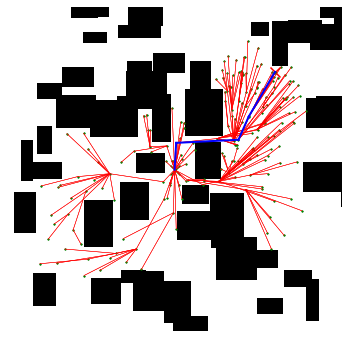

In [ ]:
#@markdown Using the same values of delta and neighbor_dist as RRT\*, see
#@markdown how many steps it takes for Informed RRT\* to reach the same
#@markdown quality of solution. Run it a few times since the number will
#@markdown depend on how soon it finds the first feasible path.
delta = 0.05 # @param {type:"slider", min:0.01, max:0.2, step:0.01}
neighbor_dist = 0.1 # @param {type:"slider", min:0.05, max:0.3, step:0.01}
max_steps = 400 # @param {type:"slider", min:100, max:1000, step:20}
nodes,G,shortest_path = Informed_RRT_star(origin, goal, obst_array,delta=delta,\
                                          neighbor_dist=.2,max_steps=max_steps)
visited_edges = [*zip(*np.nonzero(G))]

plt.figure(figsize=(6,6))
plot_task(origin,goal,obst_array)
plot_graph(nodes,visited_edges,edge_color='red')
plot_graph(nodes,shortest_path,edge_color='blue',linewidth=2)
plt.axis('off')
plt.show()

And there you have it! If you coded all those up, you've just finished your crash course in planning. A key element that we missed here was including the dynamics of the vehicle in the planning process. In the RRT-based algorithms, we push through the control dynamics to find a suitable $x_{new}$ in the direction of $x_{rand}$ within the range of feasible controls $u\in\mathcal{U}$. The edge between $x_{near}$ and $x_{new}$ keeps track of that control, so once we have the sequence of edges that produces the shortest path, we also have the sequence of controls to get there.

If you're feeling ambitious, try using the simple bicycle motion model from the last notebook and see if you can modify some of these planning algorithms to plan through the dynamics.

# Optimization
Unlike search-based methods, *optimization-based* planners achieve desired planning performance while satisfying the constraints via solving (typically nonlinear) optimiztation problems. A widely-used optimization-based planning method is **model-predictive control (MPC)**, which is demonstrated in detail in the following section.

### Model-Predictive Control

In class, we have seen how MPC can be formulated as a convex QP for control of linear dynamical systems. In this section, we will implement a slightly more complicated nonlinear MPC (NMPC) planning scheme for collision-avoidance control (with **nonconvex** constraints) of a **nonlinear** quadrotor system. 
Recall that each MPC planning cycle involves three steps: 
1.   Take a state measurement,
2.   Solve MPC for a sequence of optimized control input,
3.   Apply the first control and evolve the system,

and then resolve MPC with new state measurements (you are encouraged to implement this idea in function ```NMPC_closed_loop```). 

The quadrotor dynamics are taken from [this paper](https://hybrid-robotics.berkeley.edu/publications/ACC2016_Safety_Control_Planar_Quadrotor.pdf) and are given by,
$$
\begin{aligned}
m \ddot{x} &=F \sin \theta \\
m \ddot{y} &=F \cos \theta-m g \\
J \ddot{\theta} &=-M
\end{aligned}
$$
where $g$ is the acceleration due to gravity, $m$, $J$ are the mass and inertia of the planar quadrotor, and $F$, $M$ are scalar inputs representing the thrust and moment applied by the propellers. Subsequently, we can redefine the state of the system as $\mathbf{x}=\left[\begin{array}{llllll}
x & y & \theta & \dot{x} & \dot{y} & \dot{\theta}
\end{array}\right]^{T} .$
The failure set contains states in which the quadrotor collides with a circular obstacle defined by $\mathcal{F}:=\left\{\mathbf{x} \in \mathbb{R}^6: (x-x_{o})^{2}+(y-y_{o})^{2} \leq R_{o}^{2}\right\}$.
The target set of the quadrotor is a circular area $\mathcal{T}:=\{\mathbf{x} \in \mathbb{R}^6: (x-x_g)^{2}+(y-y_g)^{2} \leq R_g^2\}$.

In this example, we will be using the modeling software [CasADi](https://web.casadi.org/) to formulate NMPC problems, which are then solved with the interior point solver [IPOPT](https://coin-or.github.io/Ipopt/).
The NMPC problem is formulated in function ```CFTOC_NMPC```, where the objective is to regulate the quadrotor to the target region while minimizing the control effort, subject to dynamics and nonconvex collision-avoidance constraint $(x-x_o)^{2}+(y-y_o)^{2} \geq R_o^2$.


In [ ]:
# Install CasADi and IPOPT
!apt install coinor-libipopt-dev
!pip install ipopt
!pip install casadi

In [ ]:
from casadi import *
import numpy as np
import matplotlib.pylab as plt
from functools import partial
import time

In [ ]:
def ODE_RHS(x,u):
  '''Quadrotor dynamics'''
  xdot = [x[3], x[4], x[5], (u[0]/m)*np.sin(x[2]), (u[0]/m)*np.cos(x[2])-grav, -u[1]/J]
  return np.array(xdot)

def dynamics_RK4(x, u, T, N):
  '''The RK4 integrator'''
  M = 5 # RK4 steps per interval
  DT = T/N/M
  X = np.array(x)
  U = np.array(u)
  for j in range(M):
      k1 = ODE_RHS(X, U)
      k2 = ODE_RHS(X + DT/2 * k1, U)
      k3 = ODE_RHS(X + DT/2 * k2, U)
      k4 = ODE_RHS(X + DT * k3, U)
      X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
  return list(X)

def CFTOC_NMPC(x_init, x_goal, T, N):
  '''Nonlinear MPC formulated as a constrained finite-time optimal control problem (CFTOC) with CasADi'''
  nx = 6 # state dimension
  nu = 2 # control dimension
  x1 = MX.sym('x1') # Declare model variables (states and controls)
  x2 = MX.sym('x2')
  x3 = MX.sym('x3')
  x4 = MX.sym('x4')
  x5 = MX.sym('x5')
  x6 = MX.sym('x6')
  u1 = MX.sym('u1')
  u2 = MX.sym('u2')
  x  = vertcat(x1, x2, x3, x4, x5, x6)
  u  = vertcat(u1, u2)
  xdot = vertcat( x4, x5, x6, (u1/m)*sin(x3), (u1/m)*cos(x3)-grav, -u2/J ) # Dynamics
  L = 5*(x1-x_goal[0])**2 + 6*(x2-x_goal[1])**2 + 2*(x3-x_goal[2])**2 + \
      1*(x4-x_goal[3])**2 + 1*(x5-x_goal[4])**2 + 1*(x6-x_goal[5])**2 + \
      0.1*u1**2 + 5*u2**2 # Objective term (Lagrange type)
  M = 5 # RK4 steps per interval
  DT = T/N/M
  f = Function('f', [x, u], [xdot, L])
  X0 = MX.sym('X0', nx)
  U  = MX.sym('U', nu)
  X = X0
  Q = 0
  for j in range(M):
      k1, k1_q = f(X, U)
      k2, k2_q = f(X + DT/2 * k1, U)
      k3, k3_q = f(X + DT/2 * k2, U)
      k4, k4_q = f(X + DT * k3, U)
      X = X + DT/6*(k1 + 2*k2 + 2*k3 + k4)
      Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
  F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])
  # Start with an empty MPC formulation
  w  =[]
  w0 = []
  lbw = []
  ubw = []
  V = 0
  g = []
  lbg = []
  ubg = []
  # "Lift" initial conditions
  Xk = MX.sym('X0', nx)
  w += [Xk]
  lbw += x_init
  ubw += x_init
  w0  += x_init
  # Formulate the MPC problem
  for k in range(N):
      Uk = MX.sym('U_' + str(k), nu) # New variable for the control
      w   += [Uk]
      lbw += u_lb # Control lower bound
      ubw += u_ub # Control upper bound
      w0  += [0,0]

      # Collision-avoidance constraints
      Ck = MX.sym('C_' + str(k), 1)
      w   += [ Ck ]
      lbw += [ 0 ]
      ubw += [ inf ]
      w0  += [ 0 ]
      g   += [ Ck - ( (Xk[0]-xo)**2+(Xk[1]-yo)**2-obs_padding*Ro**2 ) ]
      lbg += [ 0 ]
      ubg += [ 0 ]

      Fk = F(x0=Xk, p=Uk) # Integrate dynamics and cost
      Xk_end = Fk['xf']
      V=V+Fk['qf']
      Xk = MX.sym('X_' + str(k+1), nx) # New variable for the state
      w   += [Xk]
      lbw += [-inf,-inf,-inf,-inf,-inf,-inf]
      ubw += [ inf, inf, inf, inf, inf, inf]
      w0  += [0,0,0,0,0,0]
      g   += [Xk_end-Xk] # Dynamics constraint
      lbg += [0,0,0,0,0,0]
      ubg += [0,0,0,0,0,0]
  prob = {'f': V, 'x': vertcat(*w), 'g': vertcat(*g)} # Create an MPC problem
  solver = nlpsol('solver', 'ipopt', prob,\
                  {'print_time':False, 'ipopt.print_level':0}); # Solver options
  sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg) # Solve the MPC problem
  w_opt = sol['x'].full().flatten() # Get the optimal solution
  u_opt = list(w_opt[6:8]) # Get the first optimal control input
  return u_opt

def plot_closed_loop(Xcl, Ucl, t_skip):
  '''Plot simulation results'''
  tgrid = [ts*k for k in range(Xcl.shape[0]-1)]
  plt.figure(figsize=(10,5))
  plt.clf()
  obs = plt.Circle((xo, yo), Ro, color='r', linewidth = 2.0, clip_on=False, fill=False)
  tgt = plt.Circle((xg, yg), Rg, color='g', linewidth = 2.0, clip_on=True, fill=False)
  fig = plt.gcf()
  ax = fig.gca()
  ax.add_artist(obs)
  ax.add_artist(tgt)
  plt.plot(Xcl[:,0], Xcl[:,1], 'b-', linewidth = 3.0)
  plt.plot(Xcl[0::t_skip,0], Xcl[0::t_skip,1], 'ko', markersize = 5.0)
  for t in range(0,Xcl.shape[0],t_skip):
    quad_x, quad_y = plot_quad(Xcl[t,:])
    plt.plot(quad_x, quad_y, 'k-', linewidth = 2.0)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  # plt.xlim([-3,3])
  # plt.ylim([-2,2])
  plt.axis('equal')
  plt.grid()
  # -------
  plt.figure()
  plt.clf()
  plt.step(tgrid, Ucl[:,0], '-.')
  plt.step(tgrid, Ucl[:,1], '-.')
  plt.xlabel('t (s)')
  plt.legend(['F','M'])
  plt.title('Controls')
  plt.grid()
  plt.show()

def plot_quad(x):
  '''Plot poses of the quadrotor'''
  x_out = [x[0]-L_quad*cos(x[2]), x[0]+L_quad*cos(x[2])]
  y_out = [x[1]-L_quad*sin(x[2]), x[1]+L_quad*sin(x[2])]
  return x_out, y_out

In [ ]:
#@markdown ### *Hidden closed-loop simulation implementation*
#@markdown Double click here to reveal code. To write your own, create a new codeblock below following this format and compare the outputs of the two functions. The inputs are the initial state ```x_init```, the goal state ```x_goal``` and number of simulation time steps (an integer) ```N_sim```.
#@markdown 
#@markdown During each planning cycle, you should call ```CFTOC_NMPC``` to obtain a control input by solving MPC, call ```dynamics_RK4``` to evolve the system, and check if the quadrotor reaches the target area.

#@markdown ``` def my_own_NMPC_closed_loop(x_init, x_goal, N_sim): ``` <br>
#@markdown &emsp; &emsp;``` return Xcl, Ucl #(np.array of the closed-loop state and control trajectories)```
def NMPC_closed_loop(x_init, x_goal, N_sim):
  '''Closed-loop simulations using NMPC'''
  Xcl = []
  Ucl = []
  Xcl.append(np.array(x_init))
  xt = x_init
  for t in range(N_sim):
    print('\rSimulation steps:', t+1, '/', N_sim, end='')
    u_opt = CFTOC_NMPC(xt, x_goal, T, N) # Solve the MPC problem at current time
    xt = dynamics_RK4(xt, u_opt, T, N)   # Evolve the system
    Xcl.append(np.array(xt))
    Ucl.append(np.array(u_opt))
    if np.sqrt((xt[0]-xg)**2 + (xt[1]-yg)**2) <= Rg: # Goal reached
      break
  Xcl = np.array(Xcl)
  Ucl = np.array(Ucl)
  return Xcl, Ucl

In [ ]:
#@markdown Play with the prediction horizon ```T```, number of simulation time steps ```N_sim```, location and size of the obstacle and target set. Notice how the closed-loop trajectories differ from each other.

# prediction horizon (in seconds)
T = 1.5  # @param {type:"slider", min:1.0, max:3.0, step:0.1}

# number of maximum simulation steps
N_sim = 30 # @param {type:"slider", min:10, max:50, step:1}

# obstacle x-position
xo = 4.0 # @param {type:"slider", min:2, max:6, step:0.5}

# obstacle y-position
yo = 0.0 # @param {type:"slider", min:-1, max:1, step:0.2}

# obstacle radius
Ro = 1.0 # @param {type:"slider", min:0.5, max:1.5, step:0.1}

# target set center x-position
xg = 4.0 # @param {type:"slider", min:2, max:6, step:0.5}

# target set center y-position
yg = -2.0 # @param {type:"slider", min:-2.5, max:-1.5, step:0.1}

# target set radius
Rg = 0.2 # @param {type:"slider", min:0.1, max:0.3, step:0.05}

N = int(ceil(T*10))   # number of prediction steps
ts = T/N  # sampling interval ts = T/N
u_lb  = [0., -5.] # control lower bounds
u_ub  = [15., 5.] # control upper bounds
m = 1.0  # quadrotor mass
J = 0.25 # quadrotor inertia
L_quad = 0.25 # quadrotor length
grav = 9.8 # gravitational acceleration
obs_padding = 1.3 # expand the obstacle to account for quadrotor size
x_init = [4.0, 2.0, 0.0, 0.0, 0.0, 0.0] # initial states
x_goal = [xg, yg, 0.0, 0.0, 0.0, 0.0] # target states

Simulation steps: 29 / 30

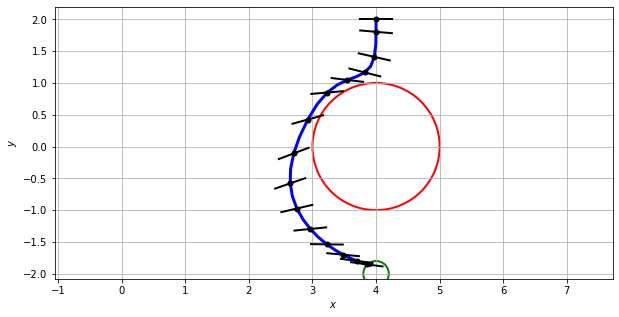

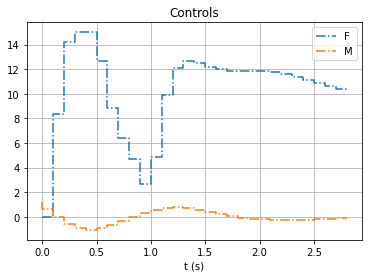

In [ ]:
# Closed-loop safe quadrotor control with NMPC
Xcl, Ucl = NMPC_closed_loop(x_init, x_goal, N_sim)

# Plot results
plot_closed_loop(Xcl, Ucl, t_skip=2)